<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2y/2y_cxcb938x6vssytccnpbdr0000gn/T/ipykernel_57078/3837818914.py:23: SyntaxWarning: invalid escape sequence '\d'
  """


Running simulation with parameters: {'v0': 0.7, 'alpha': 0.62, 'lambda_param': 1.0, 'nu_star': 200.0, 'T_steps': 5000}


Simulating INAR process: 100%|██████████| 5000/5000 [00:00<00:00, 95594.93it/s]

Simulation finished.


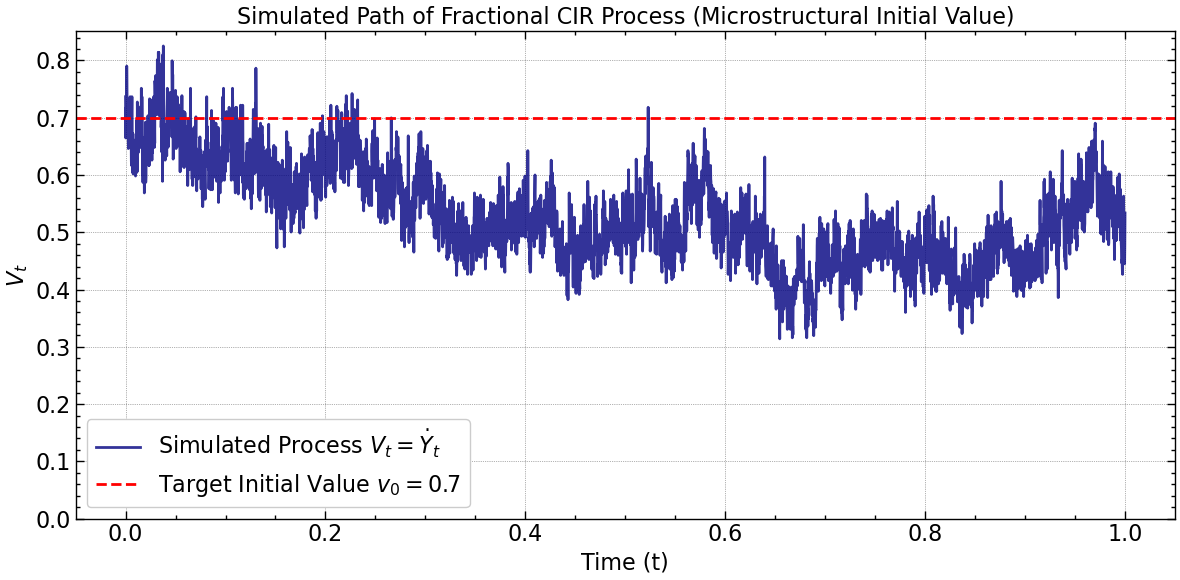


Target initial value: 0.7
Actual first point of simulated path: 0.736687


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, zeta
from tqdm import tqdm

def get_base_kernel(alpha, T_steps):
    K = 1 / zeta(1 + alpha)
    n_values = np.arange(1, T_steps + 1)
    eta_n = K / (n_values**(1 + alpha))
    return eta_n

def simulate_fcir_with_initial_value_proper(
    v0: float,
    alpha: float,
    lambda_param: float,
    nu_star: float,
    T_steps: int
):
    xi = v0

    K = 1 / zeta(1 + alpha)
    delta = K * gamma(1 - alpha) / alpha
    mu_T = nu_star * (delta**-1) * (T_steps**(alpha - 1))
    a_T = 1 - (lambda_param * delta) / (T_steps**alpha)
    
    eta_n = get_base_kernel(alpha, T_steps)
    eta_n_T = a_T * eta_n
    
    cumsum_eta_n = np.cumsum(eta_n)
    X_T = np.zeros(T_steps + 1)
    
    for n in tqdm(range(1, T_steps + 1), desc="Simulating INAR process"):
        if n == 1:
            sum_eta_so_far = 0
        else:
            sum_eta_so_far = cumsum_eta_n[n - 2]
        
        term_in_paren = (1 / (1 - a_T)) * (1 - sum_eta_so_far) - sum_eta_so_far
        hat_mu_T_n = mu_T + xi * mu_T * term_in_paren

        if n == 1:
            convolution_part = 0
        else:
            s_values = np.arange(1, n)
            kernel_values = eta_n_T[n - s_values - 1] 
            history_values = X_T[s_values]
            convolution_part = np.sum(kernel_values * history_values)
            
        lambda_n_T = hat_mu_T_n + convolution_part
        
        if lambda_n_T > 0:
            X_T[n] = np.random.poisson(lambda_n_T)

    cumulative_sum = np.cumsum(X_T)
    scaling_factor = (1 - a_T) / (T_steps**alpha * nu_star * (delta**-1))
    Y_T = scaling_factor * cumulative_sum
    t_grid = np.linspace(0, 1, T_steps + 1)
    
    V_t = np.diff(Y_T) / np.diff(t_grid)
    
    return t_grid[:-1], V_t


if __name__ == '__main__':
    params = {
        'v0': 0.7,          
        'alpha': 0.62,       
        'lambda_param': 1.0, 
        'nu_star': 200.0,    
        'T_steps': 5000      
    }

    print(f"Running simulation with parameters: {params}")
    t, V = simulate_fcir_with_initial_value_proper(**params)
    print("Simulation finished.")

    plt.figure(figsize=(12, 6))
    
    plt.plot(t, V, label=r'Simulated Process $V_t = \dot{Y}_t$', color='navy', alpha=0.8)
    plt.axhline(y=params['v0'], color='red', linestyle='--', label=f'Target Initial Value $v_0={params["v0"]}$')
    
    plt.title('Simulated Path of Fractional CIR Process (Microstructural Initial Value)')
    plt.xlabel('Time (t)')
    plt.ylabel(r'$V_t$')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    print(f"\nTarget initial value: {params['v0']}")
    print(f"Actual first point of simulated path: {V[0]:.6f}")